## Training Deep Neural Networks

# Exercises

## 1.
All weights should be sampled independently in order to break symmetry. If all the weights have the same initial value, symmetry is not broken and backpropagation will be unable to break it. This means that every neuron in a given layer would always have the same weights, which is pretty much like having one neuron per layer, but much slower.

## 2.
Yes. In fact, they can be initialized just like weights, and that's okay; it does not make much difference.

## 3.
- If the neural network is composed exclusively of a stack of dense layers that use the SELU activation function, the network will be capable of self-normalization (under the right conditions), which solves the exploding/vanishing gradients problem. 
- SELU avoids the dying units issue that can affect ReLU units because its derivative is always nonzero. 
- It can take on negative values, so the average output of neurons is typically closer to zero than when using ReLU, which helps alleviate the vanishing gradients problem.

## 4.
SELU is a good default, especially if the network meets the requirements to achieve self-normalization. Leaky ReLU (and its variants) will make the network faster if this is a concern. ReLU can be even faster thanks to optimized implementation and hardware acceleration. Its simplicity and ability to output precisely zero can be useful in some cases as well. The tanh can be useful to output values between -1 and 1, but nowadays it is not used as much in hidden layers (except in recurrent nets). The logistic function is useful for outputting probabilities, but it is rarely used in hidden layers. Lastly, softmax is useful for the output layer to output probabilities for mutually exclusive classes.

## 5.
Setting the `momentum` hyperparameter too close to 1 will allow for the `SGD` algorithm to pick up a lot of speed, but so much so that it may end up passing right past the minimum. It will probably oscillate many times until converges, so overall it will take much longer to converge than with a smaller `momentum` value.

## 6.
It is possible to obtain a sparse model by training it normally, then zeroing out tiny weights (smaller than a threshold). More sparsity can be achieved by applying $\ell_1$ regularization during training. Using the TensorFlow Model Optimization Toolkit is another option as well.

## 7.
Dropout slows down training, generally by a factor of roughly two. However, since it is only used during training, it has no impact on inference speed. MC Dropout is still active during inference, so each inference will be slowed down. More importantly, when using MC Dropout the goal is to run inference many times to get better predictions, which means that the overall inference time will be significantly higher.

## 8.

In [1]:
import os
os.environ["KERAS_BACKEND"] = 'plaidml.keras.backend'
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

Using plaidml.keras.backend backend.


### a.

In [2]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
    
model.add(keras.layers.Dense(10, activation='softmax'))

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


### b.

In [3]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

In [4]:
# Normalize the data
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [5]:
optimizer = keras.optimizers.Nadam(lr=4e-5) # Compared a few different lr with TensorBoard, and ended up with this value
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True),
]

In [7]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
          callbacks=callbacks, batch_size=256)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 8s 184us/step - loss: 2.1900 - acc: 0.2357 - val_loss: 1.9315 - val_acc: 0.3132
Epoch 2/100
45000/45000 [==============================] - 3s 65us/step - loss: 1.8625 - acc: 0.3276 - val_loss: 1.8313 - val_acc: 0.3504
Epoch 3/100
45000/45000 [==============================] - 3s 65us/step - loss: 1.7733 - acc: 0.3612 - val_loss: 1.8046 - val_acc: 0.3574
Epoch 4/100
45000/45000 [==============================] - 3s 64us/step - loss: 1.7171 - acc: 0.3836 - val_loss: 1.7247 - val_acc: 0.3856
Epoch 5/100
45000/45000 [==============================] - 3s 65us/step - loss: 1.6757 - acc: 0.3982 - val_loss: 1.7005 - val_acc: 0.3934
Epoch 6/100
45000/45000 [==============================] - 3s 64us/step - loss: 1.6408 - acc: 0.4093 - val_loss: 1.6859 - val_acc: 0.4032
Epoch 7/100
45000/45000 [==============================] - 3s 65us/step - loss: 1.6036 - acc: 0.4262 - val_loss: 1.6578 - 

In [8]:
model = keras.models.load_model('model.h5')
model.evaluate(X_val, y_val)

5000/5000 [==============================] - 2s 356us/step


[1.48999013671875, 0.4726]

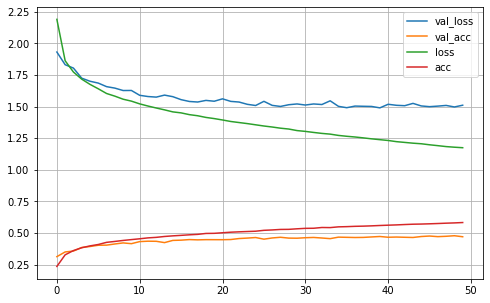

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### c.

In [10]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())

for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
    
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=4e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True),
]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=callbacks, batch_size=256)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 15s 331us/step - loss: 2.2780 - acc: 0.2062 - val_loss: 2.1130 - val_acc: 0.2628
Epoch 2/100
45000/45000 [==============================] - 5s 120us/step - loss: 1.8960 - acc: 0.3242 - val_loss: 1.8691 - val_acc: 0.3334
Epoch 3/100
45000/45000 [==============================] - 5s 122us/step - loss: 1.7624 - acc: 0.3722 - val_loss: 1.7727 - val_acc: 0.3648
Epoch 4/100
45000/45000 [==============================] - 5s 121us/step - loss: 1.6769 - acc: 0.4042 - val_loss: 1.7164 - val_acc: 0.3936
Epoch 5/100
45000/45000 [==============================] - 5s 122us/step - loss: 1.6192 - acc: 0.4245 - val_loss: 1.6829 - val_acc: 0.4042
Epoch 6/100
45000/45000 [==============================] - 6s 123us/step - loss: 1.5741 - acc: 0.4437 - val_loss: 1.6511 - val_acc: 0.4102
Epoch 7/100
45000/45000 [==============================] - 6s 125us/step - loss: 1.5311 - acc: 0.4579 - val_loss: 1.

In [11]:
model = keras.models.load_model('model.h5')
model.evaluate(X_val, y_val)

5000/5000 [==============================] - 2s 472us/step


[1.5447159324645996, 0.4568]

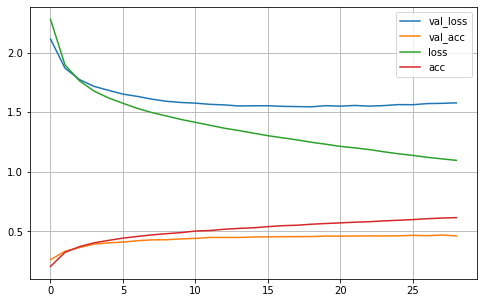

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### d.

In [13]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='lecun_normal', activation='selu'))
    
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=4e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_val_scaled = (X_val - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True),
]

history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_val_scaled, y_val),
                    callbacks=callbacks, batch_size=256)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 9s 189us/step - loss: 2.0809 - acc: 0.2760 - val_loss: 1.8983 - val_acc: 0.3256
Epoch 2/100
45000/45000 [==============================] - 3s 65us/step - loss: 1.7906 - acc: 0.3646 - val_loss: 1.8004 - val_acc: 0.3606
Epoch 3/100
45000/45000 [==============================] - 3s 66us/step - loss: 1.6921 - acc: 0.3982 - val_loss: 1.7453 - val_acc: 0.3852
Epoch 4/100
45000/45000 [==============================] - 3s 67us/step - loss: 1.6238 - acc: 0.4214 - val_loss: 1.7093 - val_acc: 0.3880
Epoch 5/100
45000/45000 [==============================] - 3s 67us/step - loss: 1.5702 - acc: 0.4413 - val_loss: 1.6775 - val_acc: 0.4026
Epoch 6/100
45000/45000 [==============================] - 3s 66us/step - loss: 1.5270 - acc: 0.4576 - val_loss: 1.6559 - val_acc: 0.4220
Epoch 7/100
45000/45000 [==============================] - 3s 67us/step - loss: 1.4863 - acc: 0.4724 - val_loss: 1.6384 - 

In [14]:
model = keras.models.load_model('model.h5')
model.evaluate(X_val_scaled, y_val)

5000/5000 [==============================] - 2s 365us/step


[1.5947628694534302, 0.444]

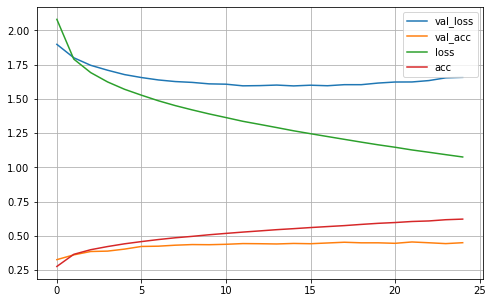

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

### e.

In [16]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='lecun_normal', activation='selu'))
    
model.add(keras.layers.AlphaDropout(rate=0.15))
model.add(keras.layers.Dense(10, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=4e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True),
]

history = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_val_scaled, y_val),
                    callbacks=callbacks, batch_size=256)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 9s 197us/step - loss: 2.3104 - acc: 0.2300 - val_loss: 1.9329 - val_acc: 0.3350
Epoch 2/100
45000/45000 [==============================] - 3s 71us/step - loss: 2.0101 - acc: 0.3078 - val_loss: 1.8208 - val_acc: 0.3712
Epoch 3/100
45000/45000 [==============================] - 3s 70us/step - loss: 1.8756 - acc: 0.3484 - val_loss: 1.7797 - val_acc: 0.3924
Epoch 4/100
45000/45000 [==============================] - 3s 69us/step - loss: 1.7808 - acc: 0.3783 - val_loss: 1.7303 - val_acc: 0.4020
Epoch 5/100
45000/45000 [==============================] - 3s 69us/step - loss: 1.7139 - acc: 0.4015 - val_loss: 1.7187 - val_acc: 0.4110
Epoch 6/100
45000/45000 [==============================] - 3s 70us/step - loss: 1.6562 - acc: 0.4204 - val_loss: 1.6897 - val_acc: 0.4234
Epoch 7/100
45000/45000 [==============================] - 3s 71us/step - loss: 1.6012 - acc: 0.4361 - val_loss: 1.6862 - 

In [17]:
model = keras.models.load_model('model.h5')
model.evaluate(X_val_scaled, y_val)

5000/5000 [==============================] - 2s 391us/step


[1.6459841396331787, 0.4508]

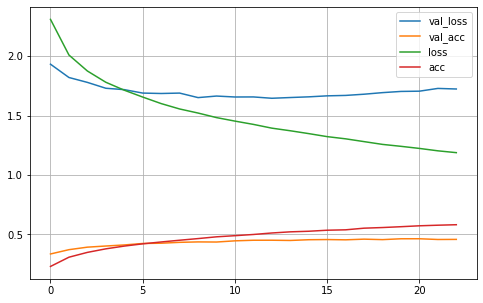

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [19]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [20]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers
])

In [21]:
n_samples = 10
y_pred = np.argmax(np.mean([mc_model.predict(X_val_scaled) for sample in range(n_samples)], axis=0), axis=1)
np.mean(y_pred == y_val[:, 0])

0.453